# Burger equation in 1D (PINN & SPINN)

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns. We see that, without any specific tuning the SPINN offers an important gain in speed and precision of the solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt
import time
key = random.PRNGKey(2)

2024-10-23 10:40:57.674411: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create the neural network architecture for the PINN

In [4]:
eqx_list = (
    (eqx.nn.Linear, 2, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 1)
)
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

Create the SPINN

In [5]:
d = 2
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r)
)
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [6]:
init_nn_params_pinn = u_pinn.init_params()
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object.

In [7]:
n = 2500
nt = 2500
nb = 2
omega_batch_size = 2500
temporal_batch_size = 2500
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
    cartesian_product=False
)

Note the `cartesian_product=False` in the cell below, which tells the `train_data_spinn` DataGenerator not to output cartesian product of space and time collocation points. It is because we use a separable PINN (SPINN) which already does similar operations internally (more precisely, outer products of each axis-dimension). 

In [8]:
train_data_spinn = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=32,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=32,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
    cartesian_product=False,
)

Let's plot the initial condition

## Model parameters

In [9]:
nu = 1 / (100 * jnp.pi)

A set of parameters as required by the losses' `evaluate` functions: a particular `Params` object that we instanciate next.

In [10]:
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "nu":nu
    }
)
init_params_spinn = jinns.parameters.Params(
    nn_params=init_nn_params_spinn,
    eq_params={
        "nu":nu
    }
)

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

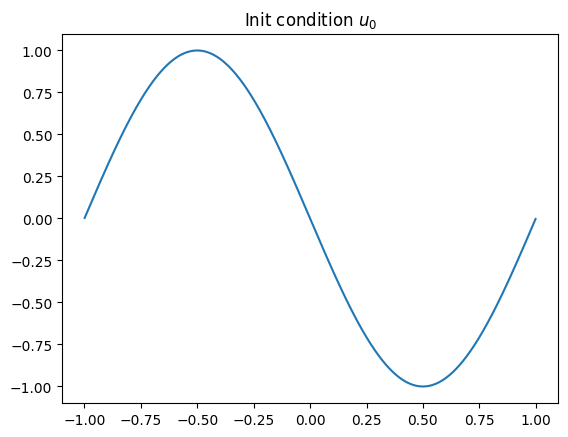

In [11]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.times_x_omega[:, 1:2].sort(axis=0), vmap(u0, (0), 0)(train_data.times_x_omega[:, 1:2].sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

In [12]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)
loss_weights = jinns.loss.LossWeightsPDENonStatio(dyn_loss=1, initial_condition=100, boundary_loss=1)

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params_pinn
)

In [13]:
import jinns.loss


loss_weights_spinn = jinns.loss.LossWeightsPDENonStatio(dyn_loss=1, initial_condition=10, boundary_loss=1)

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights_spinn,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params_spinn
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

### Train the PINN and plot loss values and solution

In [14]:
params_pinn = init_params_pinn
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 15000

params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter
)

Compilation took 2.6440114974975586
[train] Iteration 0: loss value = 59.50751495361328
[train] Iteration 1000: loss value = 0.36443230509757996
[train] Iteration 2000: loss value = 0.28503409028053284
[train] Iteration 3000: loss value = 0.25756919384002686
[train] Iteration 4000: loss value = 0.22987839579582214
[train] Iteration 5000: loss value = 0.20287872850894928
[train] Iteration 6000: loss value = 0.1538807451725006
[train] Iteration 7000: loss value = 0.04856785014271736
[train] Iteration 8000: loss value = 0.015839766710996628
[train] Iteration 9000: loss value = 0.008082146756350994
[train] Iteration 10000: loss value = 0.005225185304880142
[train] Iteration 11000: loss value = 0.003962806425988674
[train] Iteration 12000: loss value = 0.0028098570182919502
[train] Iteration 13000: loss value = 0.0023343015927821398
[train] Iteration 14000: loss value = 0.0019916894380003214
Stopping main optimization loop, cause: max iteration is reached
Training took 27.053534984588623
Fi

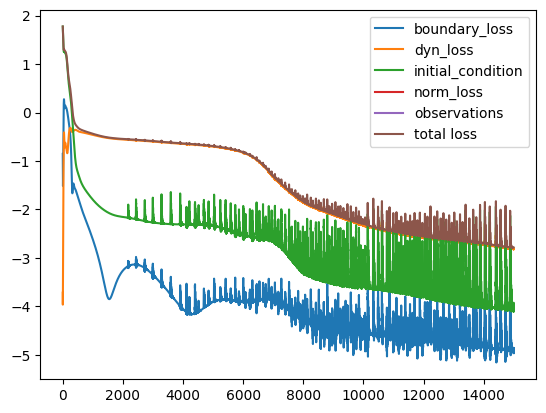

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [16]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

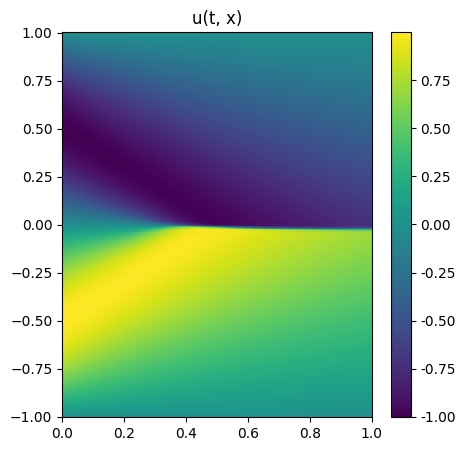

In [17]:
u_est_pinn = lambda t_x:u_pinn(t_x, params_pinn)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

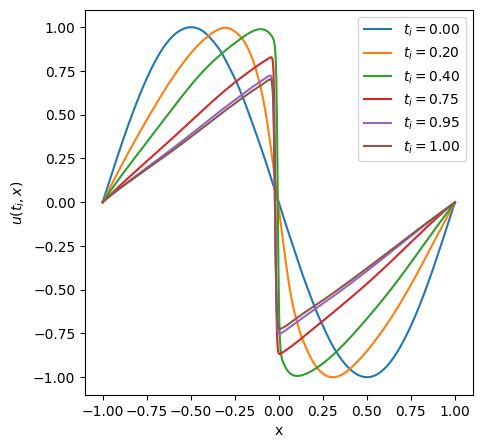

In [18]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.plot.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices,  figsize=(5, 5))

### Train the SPINN and plot loss values and solution

In [25]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 30000
params_spinn, total_loss_list_spinn, loss_by_term_dict_spinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_spinn,
    data=train_data_spinn,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter
)

Compilation took 2.462730884552002
[train] Iteration 0: loss value = 5.523709774017334
[train] Iteration 1000: loss value = 0.3760032057762146
[train] Iteration 2000: loss value = 0.36698564887046814
[train] Iteration 3000: loss value = 0.3912495970726013
[train] Iteration 4000: loss value = 0.2967207133769989
[train] Iteration 5000: loss value = 0.301588237285614
[train] Iteration 6000: loss value = 0.2796972990036011
[train] Iteration 7000: loss value = 0.23681537806987762
[train] Iteration 8000: loss value = 0.2986697554588318
[train] Iteration 9000: loss value = 0.28994905948638916
[train] Iteration 10000: loss value = 0.2097630798816681
[train] Iteration 11000: loss value = 0.24168851971626282
[train] Iteration 12000: loss value = 0.265573650598526
[train] Iteration 13000: loss value = 0.21988575160503387
[train] Iteration 14000: loss value = 0.23663529753684998
[train] Iteration 15000: loss value = 0.2512698173522949
[train] Iteration 16000: loss value = 0.18021263182163239
[trai

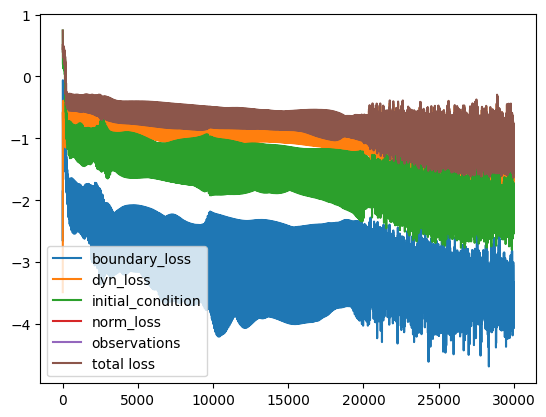

In [26]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

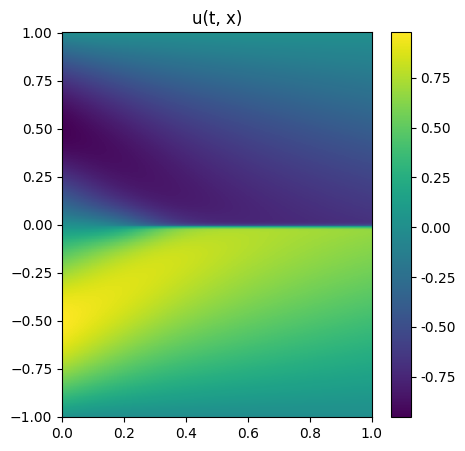

In [27]:
u_est_spinn = lambda t_x:u_spinn(t_x, params_spinn)

jinns.plot.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)", spinn=True)

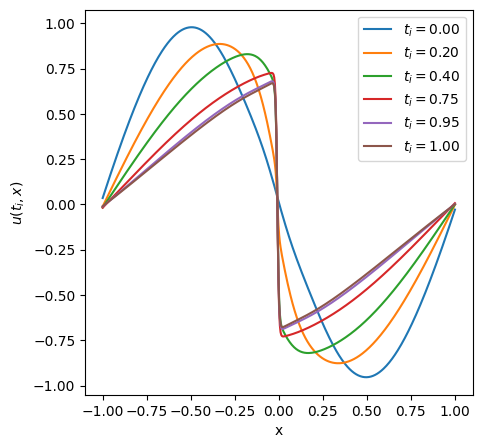

In [28]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.plot.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, spinn=True,  figsize=(5, 5))

## Conclusion

We have been able to solve the Burger PDE with jinns both with a PINN and SPINN. The PINN solution looks more accurate and is obtained approximately faster than the SPINN solution.
One could still improve the solutions by tuning the network architecture and batch size as we here used default parameters.

## Other

Save the estimated solution grid values

In [24]:
# x = test_data.omega.sort(axis=0).squeeze()
# t = test_data.times.sort(axis=0).squeeze()
# tv, xv = jnp.meshgrid(t, x)
# jnp.save("burger_t_grid.npy", tv)
# jnp.save("burger_x_grid.npy", xv)

# values = u_est_fp(tv.reshape((nt * n, 1)), xv.reshape((nt * n, 1)))
# grid = values.reshape(n, nt)
# jnp.save("burger_solution_grid.npy",
#     jnp.stack(
#         [tv, xv, grid],
#         axis=-1
#     )
# )
